In [8]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image
import os

# ============== CONFIGURACIÓN GPU ==============
print("=" * 70)
print("VERIFICACIÓN DE GPU")
print("=" * 70)

# Verificar GPUs disponibles
gpus = tf.config.list_physical_devices('GPU')
print(f"\nGPUs disponibles: {len(gpus)}")
for gpu in gpus:
    print(f"  - {gpu}")

if len(gpus) > 0:
    print("\n✓ GPU detectada correctamente!")
    
    # Configurar crecimiento dinámico de memoria (evita que TensorFlow reserve toda la VRAM)
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✓ Configuración de memoria dinámica activada")
    except RuntimeError as e:
        print(f"⚠️  Advertencia al configurar memoria: {e}")
    
    # Información adicional
    print(f"\nCUDA Version: {tf.sysconfig.get_build_info()['cuda_version']}")
    print(f"cuDNN Version: {tf.sysconfig.get_build_info()['cudnn_version']}")
else:
    print("\n⚠️  ADVERTENCIA: No se detectó GPU. Se usará CPU (será más lento)")
    print("Verifica que hayas instalado: tensorflow[and-cuda]")

print("=" * 70)

# ============== CONFIGURACIÓN ==============
DATASET_PATH = r"C:\Users\Usuario\.cache\kagglehub\datasets\philosopher0808\real-vs-ai-generated-faces-dataset\versions\1\dataset\dataset"
IMG_SIZE = 224  # Tamaño óptimo para transfer learning
BATCH_SIZE = 32  # Puedes aumentar a 64 si tienes suficiente VRAM
NUM_CLASSES = 2
EPOCHS = 50

# ============== VERIFICAR DATASET ==============
print("\nVerificando estructura del dataset...")

if not os.path.exists(DATASET_PATH):
    # Intentar con una sola carpeta "dataset"
    DATASET_PATH_ALT = DATASET_PATH.replace("dataset\\dataset", "dataset")
    if os.path.exists(DATASET_PATH_ALT):
        DATASET_PATH = DATASET_PATH_ALT
        print(f"✓ Dataset encontrado en: {DATASET_PATH}")
    else:
        raise FileNotFoundError(f"❌ No se encuentra el dataset en: {DATASET_PATH}")
else:
    print(f"✓ Dataset encontrado en: {DATASET_PATH}")

# Verificar subdirectorios
train_dir = os.path.join(DATASET_PATH, "train")
val_dir = os.path.join(DATASET_PATH, "validate")
test_dir = os.path.join(DATASET_PATH, "test")

print("\nEstructura del dataset:")
for split_name, split_dir in [("Train", train_dir), ("Validate", val_dir), ("Test", test_dir)]:
    if os.path.exists(split_dir):
        classes = [d for d in os.listdir(split_dir) if os.path.isdir(os.path.join(split_dir, d))]
        print(f"  ✓ {split_name}: {len(classes)} clases")
        for class_name in classes:
            class_path = os.path.join(split_dir, class_name)
            n_images = len([f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            print(f"      - Clase '{class_name}': {n_images} imágenes")
    else:
        raise FileNotFoundError(f"❌ No se encuentra: {split_dir}")

# ============== DATA GENERATORS ==============
print("\nConfigurando generadores de datos...")

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2]
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    directory=val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Guardar nombres de clases
class_names = list(train_generator.class_indices.keys())
print(f"\n✓ Clases detectadas: {class_names}")
print(f"✓ Total imágenes entrenamiento: {train_generator.samples}")
print(f"✓ Total imágenes validación: {val_generator.samples}")
print(f"✓ Total imágenes test: {test_generator.samples}")

# ============== CREAR MODELO CON TRANSFER LEARNING ==============
print("\n" + "=" * 70)
print("CREANDO MODELO CON TRANSFER LEARNING (MobileNetV2)")
print("=" * 70)

# Usar estrategia de distribución en GPU
strategy = tf.distribute.get_strategy()
print(f"Dispositivos disponibles: {strategy.num_replicas_in_sync}")

with strategy.scope():
    # Cargar modelo base preentrenado
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        include_top=False,
        weights='imagenet'
    )
    
    # Congelar las capas del modelo base inicialmente
    base_model.trainable = False
    
    # Crear el modelo completo
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(NUM_CLASSES, activation='softmax')
    ], name='AI_Image_Detector')
    
    # Compilar modelo
    model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )

model.summary()

# ============== CALLBACKS ==============
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=7,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'best_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

# ============== ENTRENAMIENTO FASE 1 ==============
print("\n" + "=" * 70)
print("FASE 1: ENTRENAMIENTO CON CAPAS BASE CONGELADAS")
print("=" * 70)
print("⏱️  Esto puede tardar varios minutos dependiendo del tamaño del dataset...")
print("💡 Monitorea el uso de GPU con: watch -n 1 nvidia-smi\n")

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)

# ============== FINE-TUNING FASE 2 ==============
print("\n" + "=" * 70)
print("FASE 2: FINE-TUNING (DESCONGELANDO CAPAS SUPERIORES)")
print("=" * 70)

# Descongelar las últimas capas del modelo base
base_model.trainable = True

# Congelar solo las primeras 100 capas
for layer in base_model.layers[:100]:
    layer.trainable = False

print(f"Capas entrenables: {sum([1 for layer in model.layers if layer.trainable])}")
print(f"Capas totales: {len(model.layers)}")

# Recompilar con learning rate más bajo
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# Continuar entrenamiento
history_fine = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks,
    initial_epoch=len(history.history['loss']),
    verbose=1
)

# Combinar historiales
for key in history.history.keys():
    history.history[key].extend(history_fine.history[key])

# ============== EVALUACIÓN ==============
print("\n" + "=" * 70)
print("EVALUACIÓN EN TEST SET")
print("=" * 70)

test_loss, test_acc, test_auc = model.evaluate(test_generator)
print(f"\n📊 Resultados finales:")
print(f"  • Test Loss: {test_loss:.4f}")
print(f"  • Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"  • Test AUC: {test_auc:.4f}")

# Guardar modelo final
model.save('final_model.keras')
print("\n✓ Modelo guardado como 'final_model.keras'")

# ============== VISUALIZACIÓN DE RESULTADOS ==============
print("\nGenerando gráficas de entrenamiento...")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
axes[0].plot(history.history['accuracy'], 'b', label='Train', linewidth=2)
axes[0].plot(history.history['val_accuracy'], 'r', label='Validation', linewidth=2)
axes[0].set_xlabel('Épocas', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Accuracy durante entrenamiento', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Loss
axes[1].plot(history.history['loss'], 'b', label='Train', linewidth=2)
axes[1].plot(history.history['val_loss'], 'r', label='Validation', linewidth=2)
axes[1].set_xlabel('Épocas', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Loss durante entrenamiento', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
print("✓ Gráficas guardadas como 'training_history.png'")
plt.show()

# ============== FUNCIÓN DE PREDICCIÓN ==============
def predict_image(img_path, model, class_names):
    """
    Predice si una imagen es real o generada por IA
    
    Args:
        img_path: Ruta de la imagen
        model: Modelo entrenado
        class_names: Lista con nombres de las clases
        
    Returns:
        predicted_class: Clase predicha
        confidence: Confianza de la predicción (%)
    """
    # Cargar y preprocesar imagen
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    # Predecir usando GPU
    with tf.device('/GPU:0' if len(gpus) > 0 else '/CPU:0'):
        prediction = model.predict(img_array, verbose=0)
    
    predicted_idx = np.argmax(prediction)
    predicted_class = class_names[predicted_idx]
    confidence = prediction[0][predicted_idx] * 100
    
    # Visualizar
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.title(f"Predicción: {predicted_class}\nConfianza: {confidence:.2f}%", 
              fontsize=14, fontweight='bold')
    plt.axis('off')
    
    # Añadir barra de probabilidades
    plt.text(10, img.size[1] - 10, 
             f"{class_names[0]}: {prediction[0][0]*100:.1f}%\n{class_names[1]}: {prediction[0][1]*100:.1f}%",
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
             fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n{'='*50}")
    print(f"Imagen: {os.path.basename(img_path)}")
    print(f"Predicción: {predicted_class}")
    print(f"Confianza: {confidence:.2f}%")
    print(f"Probabilidades detalladas:")
    for i, class_name in enumerate(class_names):
        print(f"  - {class_name}: {prediction[0][i]*100:.2f}%")
    print(f"{'='*50}\n")
    
    return predicted_class, confidence

# ============== PREDICCIONES DE EJEMPLO ==============
print("\n" + "=" * 70)
print("PREDICCIONES EN IMÁGENES DE PRUEBA")
print("=" * 70)

# Lista de imágenes a probar
test_images = [
    r"C:\Users\Usuario\Downloads\IA1.jpg",
    r"C:\Users\Usuario\Downloads\IA2.jpg",
    r"C:\Users\Usuario\Downloads\IA3.jpg",
    r"C:\Users\Usuario\Downloads\IA4.jpg"
]

# Filtrar solo imágenes que existen
test_images = [img for img in test_images if os.path.exists(img)]

if len(test_images) == 0:
    print("⚠️  No se encontraron imágenes de prueba en C:\\Users\\Usuario\\Downloads\\")
    print("Coloca algunas imágenes con nombres IA1.jpg, IA2.jpg, etc. para probar el modelo")
else:
    print(f"Encontradas {len(test_images)} imágenes para probar\n")
    
    # Predecir cada imagen
    results = []
    for img_path in test_images:
        try:
            predicted_class, confidence = predict_image(img_path, model, class_names)
            results.append({
                'path': img_path,
                'prediction': predicted_class,
                'confidence': confidence
            })
        except Exception as e:
            print(f"❌ Error al procesar {img_path}: {e}")
    
    # Resumen de resultados
    if results:
        print("\n" + "=" * 70)
        print("RESUMEN DE PREDICCIONES")
        print("=" * 70)
        for i, result in enumerate(results, 1):
            print(f"{i}. {os.path.basename(result['path'])}: {result['prediction']} ({result['confidence']:.2f}%)")

print("\n" + "=" * 70)
print("✓ PROCESO COMPLETADO EXITOSAMENTE")
print("=" * 70)
print(f"\nArchivos generados:")
print(f"  • best_model.keras - Mejor modelo durante entrenamiento")
print(f"  • final_model.keras - Modelo final")
print(f"  • training_history.png - Gráficas de entrenamiento")
print(f"\nPara usar el modelo en el futuro:")
print(f"  model = tf.keras.models.load_model('best_model.keras')")

VERIFICACIÓN DE GPU

GPUs disponibles: 0

⚠️  ADVERTENCIA: No se detectó GPU. Se usará CPU (será más lento)
Verifica que hayas instalado: tensorflow[and-cuda]

Verificando estructura del dataset...
✓ Dataset encontrado en: C:\Users\Usuario\.cache\kagglehub\datasets\philosopher0808\real-vs-ai-generated-faces-dataset\versions\1\dataset\dataset

Estructura del dataset:
  ✓ Train: 2 clases
      - Clase '0': 42000 imágenes
      - Clase '1': 30574 imágenes
  ✓ Validate: 2 clases
      - Clase '0': 14000 imágenes
      - Clase '1': 10190 imágenes
  ✓ Test: 2 clases
      - Clase '0': 14000 imágenes
      - Clase '1': 10190 imágenes

Configurando generadores de datos...


KeyboardInterrupt: 

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


VERIFICACIÓN DE GPU

Dispositivo seleccionado: cuda
✓ GPU detectada: NVIDIA GeForce GTX 1650 with Max-Q Design
✓ CUDA Version: 12.1
✓ Memoria GPU total: 4.00 GB
✓ Memoria GPU disponible: 0.00 GB

Verificando estructura del dataset...
✓ Dataset encontrado en: C:\Users\Usuario\.cache\kagglehub\datasets\philosopher0808\real-vs-ai-generated-faces-dataset\versions\1\dataset\dataset

Estructura del dataset:
  ✓ Train: 2 clases
      - Clase '0': 42000 imágenes
      - Clase '1': 30574 imágenes
  ✓ Validate: 2 clases
      - Clase '0': 14000 imágenes
      - Clase '1': 10190 imágenes
  ✓ Test: 2 clases
      - Clase '0': 14000 imágenes
      - Clase '1': 10190 imágenes

Configurando transformaciones y data loaders...

✓ Clases detectadas: ['0', '1']
✓ Mapeo de clases: {'0': 0, '1': 1}
✓ Total imágenes entrenamiento: 72574
✓ Total imágenes validación: 24190
✓ Total imágenes test: 24190
✓ Batches por época (train): 2268

CREANDO MODELO CON TRANSFER LEARNING (MobileNetV2)


c:\Users\Usuario\anaconda3\envs\proyectoIA_GPU\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Usuario\anaconda3\envs\proyectoIA_GPU\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\Usuario\anaconda3\envs\proyectoIA_GPU\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


✓ Modelo creado y movido a cuda
✓ Parámetros totales: 2,584,962
✓ Parámetros entrenables: 361,090

FASE 1: ENTRENAMIENTO CON CAPAS BASE CONGELADAS

Época 1/20
----------------------------------------------------------------------


Validación: 100%|██████████| 756/756 [01:36<00:00,  7.84it/s, loss=0.4816, acc=78.45%]



Resumen Época 1:
  Train Loss: 0.5373 | Train Acc: 73.52%
  Val Loss: 0.4816 | Val Acc: 78.45%
  ✓ Nuevo mejor modelo guardado! Val Acc: 78.45%

Época 2/20
----------------------------------------------------------------------


Validación: 100%|██████████| 756/756 [01:32<00:00,  8.14it/s, loss=0.4813, acc=77.44%]



Resumen Época 2:
  Train Loss: 0.5130 | Train Acc: 75.41%
  Val Loss: 0.4813 | Val Acc: 77.44%

Época 3/20
----------------------------------------------------------------------


Validación: 100%|██████████| 756/756 [01:33<00:00,  8.13it/s, loss=0.4706, acc=78.15%]



Resumen Época 3:
  Train Loss: 0.5079 | Train Acc: 75.69%
  Val Loss: 0.4706 | Val Acc: 78.15%

Época 4/20
----------------------------------------------------------------------


Validación: 100%|██████████| 756/756 [01:35<00:00,  7.95it/s, loss=0.4852, acc=79.32%]



Resumen Época 4:
  Train Loss: 0.5041 | Train Acc: 75.86%
  Val Loss: 0.4852 | Val Acc: 79.32%
  ✓ Nuevo mejor modelo guardado! Val Acc: 79.32%

Época 5/20
----------------------------------------------------------------------


Validación: 100%|██████████| 756/756 [01:35<00:00,  7.96it/s, loss=0.4837, acc=78.71%]



Resumen Época 5:
  Train Loss: 0.4997 | Train Acc: 76.35%
  Val Loss: 0.4837 | Val Acc: 78.71%

Época 6/20
----------------------------------------------------------------------


Validación: 100%|██████████| 756/756 [01:32<00:00,  8.19it/s, loss=0.5017, acc=79.53%]



Resumen Época 6:
  Train Loss: 0.4992 | Train Acc: 76.22%
  Val Loss: 0.5017 | Val Acc: 79.53%
  ✓ Nuevo mejor modelo guardado! Val Acc: 79.53%

Época 7/20
----------------------------------------------------------------------


Validación: 100%|██████████| 756/756 [01:32<00:00,  8.15it/s, loss=0.4715, acc=79.75%]



Resumen Época 7:
  Train Loss: 0.4964 | Train Acc: 76.36%
  Val Loss: 0.4715 | Val Acc: 79.75%
  ✓ Nuevo mejor modelo guardado! Val Acc: 79.75%

Época 8/20
----------------------------------------------------------------------


Validación: 100%|██████████| 756/756 [01:33<00:00,  8.06it/s, loss=0.4728, acc=80.16%]



Resumen Época 8:
  Train Loss: 0.4865 | Train Acc: 76.85%
  Val Loss: 0.4728 | Val Acc: 80.16%
  ✓ Nuevo mejor modelo guardado! Val Acc: 80.16%

Época 9/20
----------------------------------------------------------------------


Validación: 100%|██████████| 756/756 [01:33<00:00,  8.07it/s, loss=0.4869, acc=79.42%]



Resumen Época 9:
  Train Loss: 0.4848 | Train Acc: 76.97%
  Val Loss: 0.4869 | Val Acc: 79.42%

Época 10/20
----------------------------------------------------------------------


Validación: 100%|██████████| 756/756 [01:32<00:00,  8.19it/s, loss=0.4620, acc=80.26%]



Resumen Época 10:
  Train Loss: 0.4823 | Train Acc: 77.18%
  Val Loss: 0.4620 | Val Acc: 80.26%
  ✓ Nuevo mejor modelo guardado! Val Acc: 80.26%

Época 11/20
----------------------------------------------------------------------


Validación: 100%|██████████| 756/756 [01:32<00:00,  8.16it/s, loss=0.4854, acc=79.02%]



Resumen Época 11:
  Train Loss: 0.4834 | Train Acc: 77.12%
  Val Loss: 0.4854 | Val Acc: 79.02%

Época 12/20
----------------------------------------------------------------------


Validación: 100%|██████████| 756/756 [01:32<00:00,  8.17it/s, loss=0.4752, acc=80.15%]



Resumen Época 12:
  Train Loss: 0.4812 | Train Acc: 77.13%
  Val Loss: 0.4752 | Val Acc: 80.15%

Época 13/20
----------------------------------------------------------------------


Validación: 100%|██████████| 756/756 [01:32<00:00,  8.21it/s, loss=0.4836, acc=79.84%]



Resumen Época 13:
  Train Loss: 0.4813 | Train Acc: 77.17%
  Val Loss: 0.4836 | Val Acc: 79.84%

Época 14/20
----------------------------------------------------------------------


Validación: 100%|██████████| 756/756 [01:31<00:00,  8.23it/s, loss=0.4876, acc=80.07%]



Resumen Época 14:
  Train Loss: 0.4794 | Train Acc: 77.10%
  Val Loss: 0.4876 | Val Acc: 80.07%

Época 15/20
----------------------------------------------------------------------


Validación: 100%|██████████| 756/756 [01:30<00:00,  8.36it/s, loss=0.4815, acc=79.99%]



Resumen Época 15:
  Train Loss: 0.4767 | Train Acc: 77.37%
  Val Loss: 0.4815 | Val Acc: 79.99%

Época 16/20
----------------------------------------------------------------------


Validación: 100%|██████████| 756/756 [01:32<00:00,  8.17it/s, loss=0.4830, acc=79.72%]



Resumen Época 16:
  Train Loss: 0.4765 | Train Acc: 77.46%
  Val Loss: 0.4830 | Val Acc: 79.72%

Época 17/20
----------------------------------------------------------------------


Validación: 100%|██████████| 756/756 [01:30<00:00,  8.38it/s, loss=0.4758, acc=80.41%]



Resumen Época 17:
  Train Loss: 0.4722 | Train Acc: 77.69%
  Val Loss: 0.4758 | Val Acc: 80.41%
  ✓ Nuevo mejor modelo guardado! Val Acc: 80.41%

Época 18/20
----------------------------------------------------------------------


Validación: 100%|██████████| 756/756 [01:32<00:00,  8.16it/s, loss=0.4818, acc=80.55%]



Resumen Época 18:
  Train Loss: 0.4717 | Train Acc: 77.60%
  Val Loss: 0.4818 | Val Acc: 80.55%
  ✓ Nuevo mejor modelo guardado! Val Acc: 80.55%

Época 19/20
----------------------------------------------------------------------


Validación: 100%|██████████| 756/756 [01:32<00:00,  8.19it/s, loss=0.4745, acc=80.61%]



Resumen Época 19:
  Train Loss: 0.4732 | Train Acc: 77.53%
  Val Loss: 0.4745 | Val Acc: 80.61%
  ✓ Nuevo mejor modelo guardado! Val Acc: 80.61%

Época 20/20
----------------------------------------------------------------------


Validación: 100%|██████████| 756/756 [01:33<00:00,  8.13it/s, loss=0.4905, acc=80.12%]
C:\Users\Usuario\AppData\Local\Temp\ipykernel_17592\3869895995.py:258: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related t


Resumen Época 20:
  Train Loss: 0.4710 | Train Acc: 77.83%
  Val Loss: 0.4905 | Val Acc: 80.12%

FASE 2: FINE-TUNING (DESCONGELANDO CAPAS SUPERIORES)
✓ Parámetros entrenables después de descongelar: 2,278,978

Época 21/70
----------------------------------------------------------------------


Validación: 100%|██████████| 756/756 [01:32<00:00,  8.15it/s, loss=0.2598, acc=92.67%] 



Resumen Época 21:
  Train Loss: 0.3160 | Train Acc: 86.59%
  Val Loss: 0.2598 | Val Acc: 92.67%
  ✓ Nuevo mejor modelo guardado! Val Acc: 92.67%

Época 22/70
----------------------------------------------------------------------


Validación: 100%|██████████| 756/756 [01:32<00:00,  8.17it/s, loss=0.2029, acc=94.04%] 



Resumen Época 22:
  Train Loss: 0.2061 | Train Acc: 92.14%
  Val Loss: 0.2029 | Val Acc: 94.04%
  ✓ Nuevo mejor modelo guardado! Val Acc: 94.04%

Época 23/70
----------------------------------------------------------------------


Validación: 100%|██████████| 756/756 [01:33<00:00,  8.12it/s, loss=0.2196, acc=93.33%]



Resumen Época 23:
  Train Loss: 0.1660 | Train Acc: 93.86%
  Val Loss: 0.2196 | Val Acc: 93.33%

Época 24/70
----------------------------------------------------------------------


Validación: 100%|██████████| 756/756 [01:30<00:00,  8.38it/s, loss=0.1620, acc=95.10%] 



Resumen Época 24:
  Train Loss: 0.1413 | Train Acc: 94.82%
  Val Loss: 0.1620 | Val Acc: 95.10%
  ✓ Nuevo mejor modelo guardado! Val Acc: 95.10%

Época 25/70
----------------------------------------------------------------------


Validación: 100%|██████████| 756/756 [01:30<00:00,  8.37it/s, loss=0.1190, acc=96.86%] 



Resumen Época 25:
  Train Loss: 0.1250 | Train Acc: 95.46%
  Val Loss: 0.1190 | Val Acc: 96.86%
  ✓ Nuevo mejor modelo guardado! Val Acc: 96.86%

Época 26/70
----------------------------------------------------------------------


Validación: 100%|██████████| 756/756 [01:32<00:00,  8.17it/s, loss=0.1124, acc=96.54%] 



Resumen Época 26:
  Train Loss: 0.1128 | Train Acc: 95.87%
  Val Loss: 0.1124 | Val Acc: 96.54%

Época 27/70
----------------------------------------------------------------------


Validación: 100%|██████████| 756/756 [01:32<00:00,  8.20it/s, loss=0.1079, acc=97.18%] 



Resumen Época 27:
  Train Loss: 0.1025 | Train Acc: 96.26%
  Val Loss: 0.1079 | Val Acc: 97.18%
  ✓ Nuevo mejor modelo guardado! Val Acc: 97.18%

Época 28/70
----------------------------------------------------------------------


Validación: 100%|██████████| 756/756 [01:30<00:00,  8.37it/s, loss=0.0979, acc=97.11%] 



Resumen Época 28:
  Train Loss: 0.0935 | Train Acc: 96.63%
  Val Loss: 0.0979 | Val Acc: 97.11%

Época 29/70
----------------------------------------------------------------------


Validación: 100%|██████████| 756/756 [01:33<00:00,  8.12it/s, loss=0.0879, acc=97.30%] 



Resumen Época 29:
  Train Loss: 0.0852 | Train Acc: 96.93%
  Val Loss: 0.0879 | Val Acc: 97.30%
  ✓ Nuevo mejor modelo guardado! Val Acc: 97.30%

Época 30/70
----------------------------------------------------------------------


Validación: 100%|██████████| 756/756 [01:32<00:00,  8.13it/s, loss=0.0944, acc=96.75%] 



Resumen Época 30:
  Train Loss: 0.0807 | Train Acc: 97.02%
  Val Loss: 0.0944 | Val Acc: 96.75%

Época 31/70
----------------------------------------------------------------------


Validación: 100%|██████████| 756/756 [01:33<00:00,  8.12it/s, loss=0.0950, acc=96.72%] 



Resumen Época 31:
  Train Loss: 0.0763 | Train Acc: 97.29%
  Val Loss: 0.0950 | Val Acc: 96.72%

Época 32/70
----------------------------------------------------------------------


Validación: 100%|██████████| 756/756 [01:33<00:00,  8.07it/s, loss=0.0979, acc=96.87%] 



Resumen Época 32:
  Train Loss: 0.0695 | Train Acc: 97.48%
  Val Loss: 0.0979 | Val Acc: 96.87%

Época 33/70
----------------------------------------------------------------------


Validación: 100%|██████████| 756/756 [01:32<00:00,  8.18it/s, loss=0.0993, acc=96.57%] 



Resumen Época 33:
  Train Loss: 0.0681 | Train Acc: 97.53%
  Val Loss: 0.0993 | Val Acc: 96.57%

Época 34/70
----------------------------------------------------------------------


Validación: 100%|██████████| 756/756 [01:50<00:00,  6.82it/s, loss=0.0697, acc=97.68%] 



Resumen Época 34:
  Train Loss: 0.0489 | Train Acc: 98.26%
  Val Loss: 0.0697 | Val Acc: 97.68%
  ✓ Nuevo mejor modelo guardado! Val Acc: 97.68%

Época 35/70
----------------------------------------------------------------------


Validación: 100%|██████████| 756/756 [01:32<00:00,  8.16it/s, loss=0.0730, acc=97.61%] 



Resumen Época 35:
  Train Loss: 0.0435 | Train Acc: 98.52%
  Val Loss: 0.0730 | Val Acc: 97.61%

Época 36/70
----------------------------------------------------------------------


Validación: 100%|██████████| 756/756 [01:32<00:00,  8.18it/s, loss=0.0640, acc=97.97%] 



Resumen Época 36:
  Train Loss: 0.0404 | Train Acc: 98.54%
  Val Loss: 0.0640 | Val Acc: 97.97%
  ✓ Nuevo mejor modelo guardado! Val Acc: 97.97%

Época 37/70
----------------------------------------------------------------------


Validación: 100%|██████████| 756/756 [01:32<00:00,  8.17it/s, loss=0.0607, acc=97.96%] 



Resumen Época 37:
  Train Loss: 0.0387 | Train Acc: 98.70%
  Val Loss: 0.0607 | Val Acc: 97.96%

Época 38/70
----------------------------------------------------------------------


Validación: 100%|██████████| 756/756 [01:30<00:00,  8.38it/s, loss=0.0640, acc=97.89%] 



Resumen Época 38:
  Train Loss: 0.0369 | Train Acc: 98.70%
  Val Loss: 0.0640 | Val Acc: 97.89%

Época 39/70
----------------------------------------------------------------------


Validación: 100%|██████████| 756/756 [01:30<00:00,  8.39it/s, loss=0.0646, acc=97.88%] 



Resumen Época 39:
  Train Loss: 0.0343 | Train Acc: 98.80%
  Val Loss: 0.0646 | Val Acc: 97.88%

Época 40/70
----------------------------------------------------------------------


Validación: 100%|██████████| 756/756 [01:31<00:00,  8.24it/s, loss=0.0590, acc=98.07%] 



Resumen Época 40:
  Train Loss: 0.0324 | Train Acc: 98.81%
  Val Loss: 0.0590 | Val Acc: 98.07%
  ✓ Nuevo mejor modelo guardado! Val Acc: 98.07%

Época 41/70
----------------------------------------------------------------------


Validación: 100%|██████████| 756/756 [01:32<00:00,  8.21it/s, loss=0.0655, acc=97.78%] 



Resumen Época 41:
  Train Loss: 0.0328 | Train Acc: 98.83%
  Val Loss: 0.0655 | Val Acc: 97.78%

Época 42/70
----------------------------------------------------------------------


Validación: 100%|██████████| 756/756 [01:31<00:00,  8.25it/s, loss=0.0648, acc=97.78%] 



Resumen Época 42:
  Train Loss: 0.0313 | Train Acc: 98.89%
  Val Loss: 0.0648 | Val Acc: 97.78%

Época 43/70
----------------------------------------------------------------------


Validación: 100%|██████████| 756/756 [01:32<00:00,  8.18it/s, loss=0.0564, acc=98.12%] 



Resumen Época 43:
  Train Loss: 0.0312 | Train Acc: 98.89%
  Val Loss: 0.0564 | Val Acc: 98.12%
  ✓ Nuevo mejor modelo guardado! Val Acc: 98.12%

Época 44/70
----------------------------------------------------------------------


Validación: 100%|██████████| 756/756 [01:32<00:00,  8.15it/s, loss=0.0599, acc=97.96%] 



Resumen Época 44:
  Train Loss: 0.0300 | Train Acc: 98.89%
  Val Loss: 0.0599 | Val Acc: 97.96%

Época 45/70
----------------------------------------------------------------------


Validación: 100%|██████████| 756/756 [01:32<00:00,  8.18it/s, loss=0.0645, acc=97.71%] 



Resumen Época 45:
  Train Loss: 0.0281 | Train Acc: 98.97%
  Val Loss: 0.0645 | Val Acc: 97.71%

Época 46/70
----------------------------------------------------------------------


Validación: 100%|██████████| 756/756 [01:32<00:00,  8.16it/s, loss=0.0648, acc=97.78%] 



Resumen Época 46:
  Train Loss: 0.0268 | Train Acc: 99.03%
  Val Loss: 0.0648 | Val Acc: 97.78%

Época 47/70
----------------------------------------------------------------------


Validación: 100%|██████████| 756/756 [01:32<00:00,  8.15it/s, loss=0.0614, acc=98.04%] 



Resumen Época 47:
  Train Loss: 0.0268 | Train Acc: 99.06%
  Val Loss: 0.0614 | Val Acc: 98.04%

Época 48/70
----------------------------------------------------------------------


Validación: 100%|██████████| 756/756 [01:32<00:00,  8.14it/s, loss=0.0587, acc=98.02%] 



Resumen Época 48:
  Train Loss: 0.0213 | Train Acc: 99.24%
  Val Loss: 0.0587 | Val Acc: 98.02%

Época 49/70
----------------------------------------------------------------------


Validación: 100%|██████████| 756/756 [01:32<00:00,  8.16it/s, loss=0.0708, acc=97.64%] 



Resumen Época 49:
  Train Loss: 0.0185 | Train Acc: 99.34%
  Val Loss: 0.0708 | Val Acc: 97.64%

Época 50/70
----------------------------------------------------------------------


Validación: 100%|██████████| 756/756 [01:32<00:00,  8.13it/s, loss=0.0540, acc=98.29%] 



Resumen Época 50:
  Train Loss: 0.0186 | Train Acc: 99.34%
  Val Loss: 0.0540 | Val Acc: 98.29%
  ✓ Nuevo mejor modelo guardado! Val Acc: 98.29%

Época 51/70
----------------------------------------------------------------------


Validación: 100%|██████████| 756/756 [01:33<00:00,  8.12it/s, loss=0.0591, acc=98.10%] 



Resumen Época 51:
  Train Loss: 0.0168 | Train Acc: 99.38%
  Val Loss: 0.0591 | Val Acc: 98.10%

Época 52/70
----------------------------------------------------------------------


Validación: 100%|██████████| 756/756 [01:31<00:00,  8.24it/s, loss=0.0519, acc=98.37%] 



Resumen Época 52:
  Train Loss: 0.0155 | Train Acc: 99.48%
  Val Loss: 0.0519 | Val Acc: 98.37%
  ✓ Nuevo mejor modelo guardado! Val Acc: 98.37%

Época 53/70
----------------------------------------------------------------------


Validación: 100%|██████████| 756/756 [01:31<00:00,  8.25it/s, loss=0.0546, acc=98.35%] 



Resumen Época 53:
  Train Loss: 0.0166 | Train Acc: 99.46%
  Val Loss: 0.0546 | Val Acc: 98.35%

Época 54/70
----------------------------------------------------------------------


Validación: 100%|██████████| 756/756 [01:32<00:00,  8.21it/s, loss=0.0542, acc=98.30%] 



Resumen Época 54:
  Train Loss: 0.0166 | Train Acc: 99.42%
  Val Loss: 0.0542 | Val Acc: 98.30%

Época 55/70
----------------------------------------------------------------------


Validación: 100%|██████████| 756/756 [01:32<00:00,  8.14it/s, loss=0.0528, acc=98.31%] 



Resumen Época 55:
  Train Loss: 0.0151 | Train Acc: 99.49%
  Val Loss: 0.0528 | Val Acc: 98.31%

Época 56/70
----------------------------------------------------------------------


Validación: 100%|██████████| 756/756 [01:51<00:00,  6.81it/s, loss=0.0562, acc=98.18%] 



Resumen Época 56:
  Train Loss: 0.0152 | Train Acc: 99.44%
  Val Loss: 0.0562 | Val Acc: 98.18%

Época 57/70
----------------------------------------------------------------------


Validación: 100%|██████████| 756/756 [01:33<00:00,  8.13it/s, loss=0.0533, acc=98.27%] 



Resumen Época 57:
  Train Loss: 0.0123 | Train Acc: 99.56%
  Val Loss: 0.0533 | Val Acc: 98.27%

Época 58/70
----------------------------------------------------------------------


Validación: 100%|██████████| 756/756 [01:32<00:00,  8.15it/s, loss=0.0557, acc=98.21%] 



Resumen Época 58:
  Train Loss: 0.0118 | Train Acc: 99.57%
  Val Loss: 0.0557 | Val Acc: 98.21%

Época 59/70
----------------------------------------------------------------------


Validación: 100%|██████████| 756/756 [01:32<00:00,  8.17it/s, loss=0.0610, acc=97.92%] 
C:\Users\Usuario\AppData\Local\Temp\ipykernel_17592\3869895995.py:316: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related 


Resumen Época 59:
  Train Loss: 0.0117 | Train Acc: 99.60%
  Val Loss: 0.0610 | Val Acc: 97.92%

⚠️  Early stopping activado (sin mejora en 7 épocas)

EVALUACIÓN EN TEST SET


Validación: 100%|██████████| 756/756 [01:32<00:00,  8.21it/s, loss=0.0514, acc=98.22%] 



📊 Resultados finales:
  • Test Loss: 0.0514
  • Test Accuracy: 0.9822 (98.22%)
  • Mejor Val Accuracy: 98.37%

✓ Modelo final guardado como 'final_model.pth'
✓ Historial guardado como 'history.json'

Generando gráficas de entrenamiento...
✓ Gráficas guardadas como 'training_history.png'


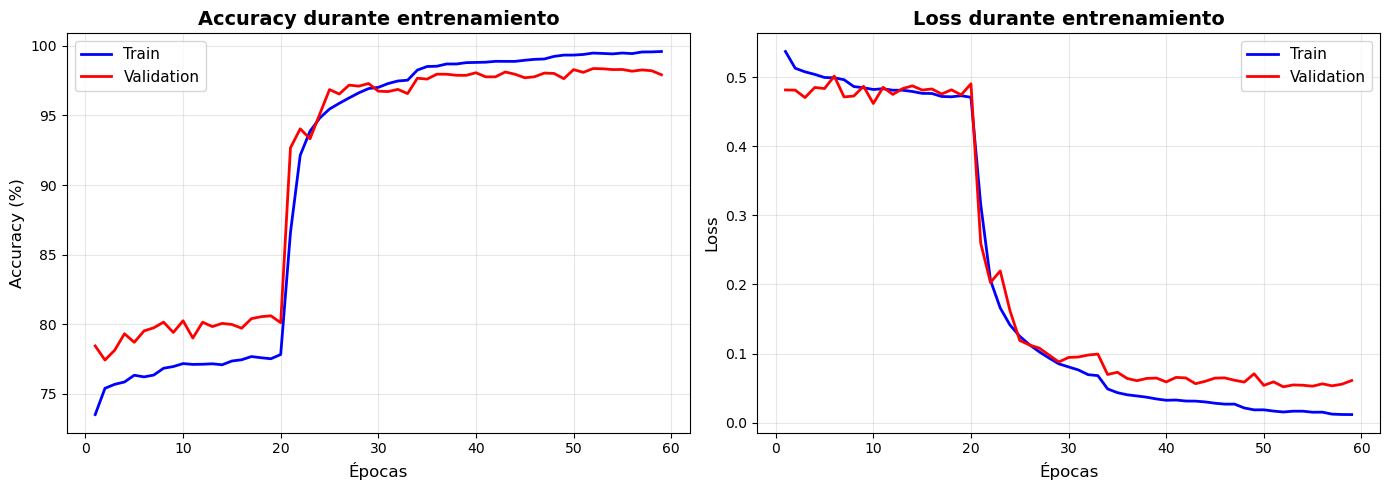


PREDICCIONES EN IMÁGENES DE PRUEBA
Encontradas 4 imágenes para probar



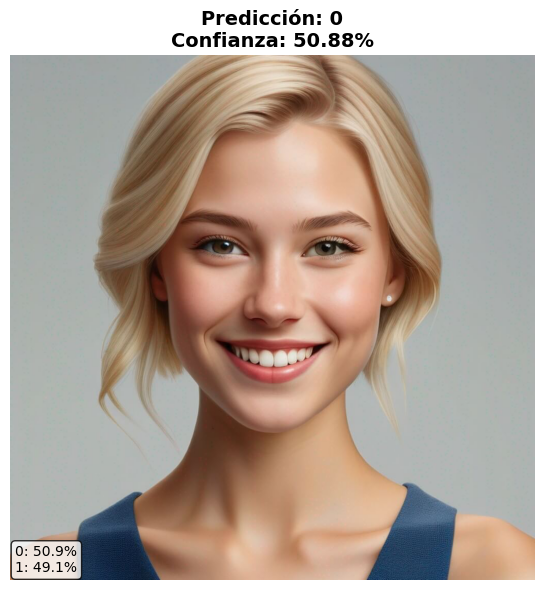


Imagen: IA1.jpg
Predicción: 0
Confianza: 50.88%
Probabilidades detalladas:
  - 0: 50.88%
  - 1: 49.12%



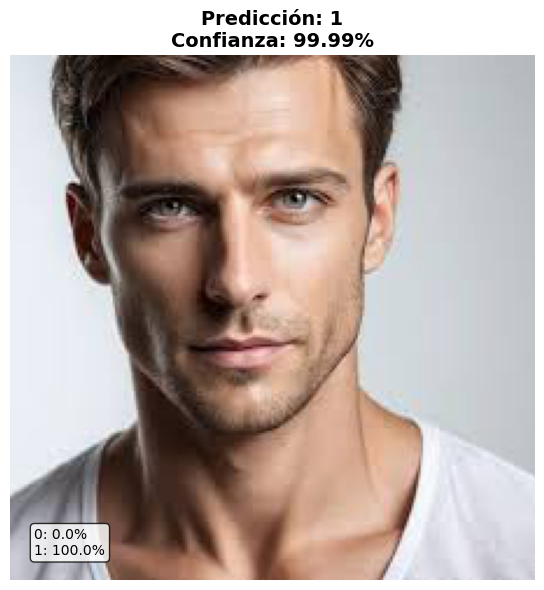


Imagen: IA2.jpg
Predicción: 1
Confianza: 99.99%
Probabilidades detalladas:
  - 0: 0.01%
  - 1: 99.99%



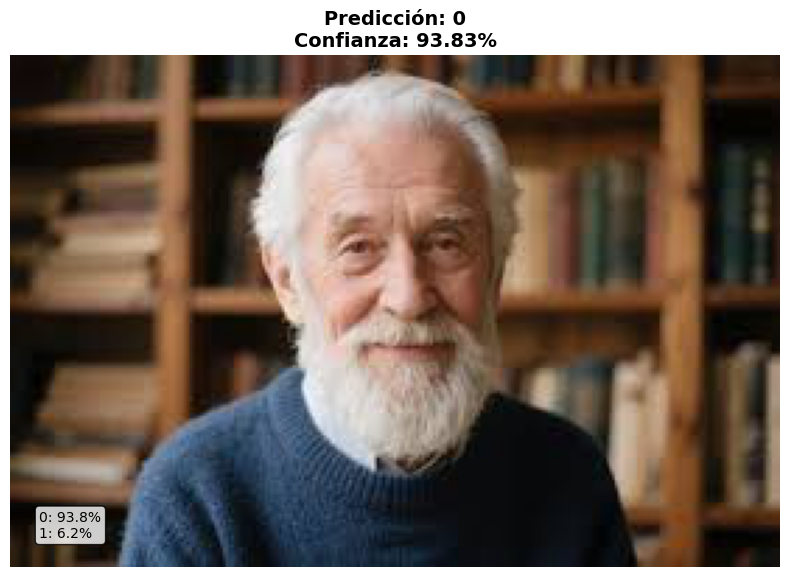


Imagen: IA3.jpg
Predicción: 0
Confianza: 93.83%
Probabilidades detalladas:
  - 0: 93.83%
  - 1: 6.17%



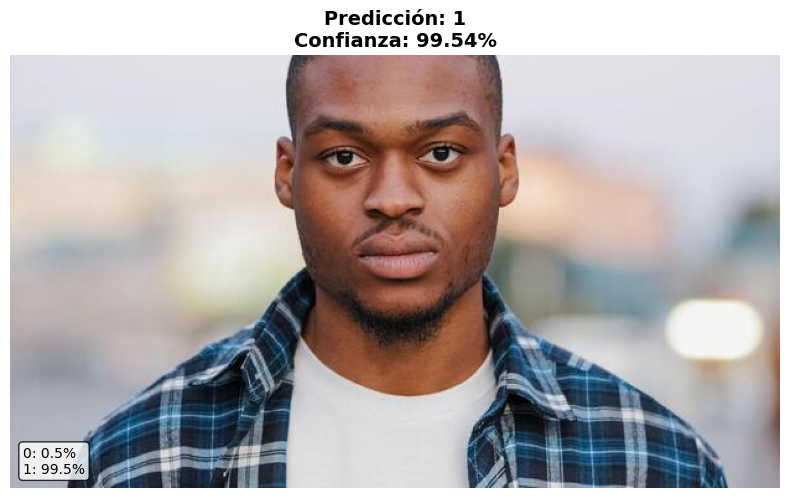


Imagen: IA4.jpg
Predicción: 1
Confianza: 99.54%
Probabilidades detalladas:
  - 0: 0.46%
  - 1: 99.54%


RESUMEN DE PREDICCIONES
1. IA1.jpg: 0 (50.88%)
2. IA2.jpg: 1 (99.99%)
3. IA3.jpg: 0 (93.83%)
4. IA4.jpg: 1 (99.54%)

✓ PROCESO COMPLETADO EXITOSAMENTE

Archivos generados:
  • best_model.pth - Mejor modelo durante entrenamiento
  • final_model.pth - Modelo final
  • history.json - Historial de entrenamiento
  • training_history.png - Gráficas

Para usar el modelo:
  checkpoint = torch.load('best_model.pth')
  model.load_state_dict(checkpoint['model_state_dict'])


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from PIL import Image
import os
from tqdm import tqdm
import json

# ============== CONFIGURACIÓN GPU ==============
print("=" * 70)
print("VERIFICACIÓN DE GPU")
print("=" * 70)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nDispositivo seleccionado: {device}")

if torch.cuda.is_available():
    print(f"✓ GPU detectada: {torch.cuda.get_device_name(0)}")
    print(f"✓ CUDA Version: {torch.version.cuda}")
    print(f"✓ Memoria GPU total: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
    print(f"✓ Memoria GPU disponible: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB")
else:
    print("⚠️  ADVERTENCIA: No se detectó GPU. Se usará CPU (será más lento)")
    print("Verifica que hayas instalado: pip install torch torchvision --index-url https://download.pytorch.org/whl/cu121")

print("=" * 70)

# ============== CONFIGURACIÓN ==============
DATASET_PATH = r"C:\Users\Usuario\.cache\kagglehub\datasets\philosopher0808\real-vs-ai-generated-faces-dataset\versions\1\dataset\dataset"
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 2
EPOCHS = 50
LEARNING_RATE = 0.001

# ============== VERIFICAR DATASET ==============
print("\nVerificando estructura del dataset...")

if not os.path.exists(DATASET_PATH):
    DATASET_PATH_ALT = DATASET_PATH.replace("dataset\\dataset", "dataset")
    if os.path.exists(DATASET_PATH_ALT):
        DATASET_PATH = DATASET_PATH_ALT
        print(f"✓ Dataset encontrado en: {DATASET_PATH}")
    else:
        raise FileNotFoundError(f"❌ No se encuentra el dataset en: {DATASET_PATH}")
else:
    print(f"✓ Dataset encontrado en: {DATASET_PATH}")

train_dir = os.path.join(DATASET_PATH, "train")
val_dir = os.path.join(DATASET_PATH, "validate")
test_dir = os.path.join(DATASET_PATH, "test")

print("\nEstructura del dataset:")
for split_name, split_dir in [("Train", train_dir), ("Validate", val_dir), ("Test", test_dir)]:
    if os.path.exists(split_dir):
        classes = [d for d in os.listdir(split_dir) if os.path.isdir(os.path.join(split_dir, d))]
        print(f"  ✓ {split_name}: {len(classes)} clases")
        for class_name in classes:
            class_path = os.path.join(split_dir, class_name)
            n_images = len([f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            print(f"      - Clase '{class_name}': {n_images} imágenes")
    else:
        raise FileNotFoundError(f"❌ No se encuentra: {split_dir}")

# ============== TRANSFORMACIONES Y DATA LOADERS ==============
print("\nConfigurando transformaciones y data loaders...")

# Transformaciones para entrenamiento (con data augmentation)
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Transformaciones para validación y test (sin augmentation)
val_test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Crear datasets
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(val_dir, transform=val_test_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=val_test_transforms)

# Crear data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

# Guardar nombres de clases
class_names = train_dataset.classes
class_to_idx = train_dataset.class_to_idx

print(f"\n✓ Clases detectadas: {class_names}")
print(f"✓ Mapeo de clases: {class_to_idx}")
print(f"✓ Total imágenes entrenamiento: {len(train_dataset)}")
print(f"✓ Total imágenes validación: {len(val_dataset)}")
print(f"✓ Total imágenes test: {len(test_dataset)}")
print(f"✓ Batches por época (train): {len(train_loader)}")

# ============== CREAR MODELO CON TRANSFER LEARNING ==============
print("\n" + "=" * 70)
print("CREANDO MODELO CON TRANSFER LEARNING (MobileNetV2)")
print("=" * 70)

# Cargar MobileNetV2 preentrenado
model = models.mobilenet_v2(pretrained=True)

# Congelar todas las capas del modelo base
for param in model.parameters():
    param.requires_grad = False

# Modificar la última capa para nuestro problema (2 clases)
model.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(model.last_channel, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(128, NUM_CLASSES)
)

# Mover modelo a GPU
model = model.to(device)

print(f"✓ Modelo creado y movido a {device}")
print(f"✓ Parámetros totales: {sum(p.numel() for p in model.parameters()):,}")
print(f"✓ Parámetros entrenables: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# ============== CONFIGURAR ENTRENAMIENTO ==============
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# ============== FUNCIONES DE ENTRENAMIENTO Y VALIDACIÓN ==============
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc='Entrenamiento')
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        pbar.set_postfix({'loss': f'{running_loss/len(loader):.4f}', 
                         'acc': f'{100.*correct/total:.2f}%'})
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        pbar = tqdm(loader, desc='Validación')
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            pbar.set_postfix({'loss': f'{running_loss/len(loader):.4f}', 
                             'acc': f'{100.*correct/total:.2f}%'})
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# ============== ENTRENAMIENTO FASE 1 ==============
print("\n" + "=" * 70)
print("FASE 1: ENTRENAMIENTO CON CAPAS BASE CONGELADAS")
print("=" * 70)

history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

best_val_acc = 0.0
patience_counter = 0
max_patience = 7

for epoch in range(20):
    print(f"\nÉpoca {epoch+1}/20")
    print("-" * 70)
    
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    scheduler.step(val_loss)
    
    print(f"\nResumen Época {epoch+1}:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")
    
    # Guardar mejor modelo
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'class_names': class_names,
            'class_to_idx': class_to_idx
        }, 'best_model.pth')
        print(f"  ✓ Nuevo mejor modelo guardado! Val Acc: {val_acc*100:.2f}%")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= max_patience:
            print(f"\n⚠️  Early stopping activado (sin mejora en {max_patience} épocas)")
            break

# ============== FINE-TUNING FASE 2 ==============
print("\n" + "=" * 70)
print("FASE 2: FINE-TUNING (DESCONGELANDO CAPAS SUPERIORES)")
print("=" * 70)

# Cargar mejor modelo de fase 1
checkpoint = torch.load('best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])

# Descongelar las últimas capas
for param in model.features[-7:].parameters():
    param.requires_grad = True

# Nuevo optimizador con learning rate más bajo
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE/10)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

print(f"✓ Parámetros entrenables después de descongelar: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

best_val_acc = checkpoint['val_acc']
patience_counter = 0

for epoch in range(EPOCHS):
    print(f"\nÉpoca {epoch+21}/{EPOCHS+20}")
    print("-" * 70)
    
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    scheduler.step(val_loss)
    
    print(f"\nResumen Época {epoch+21}:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch + 20,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'class_names': class_names,
            'class_to_idx': class_to_idx
        }, 'best_model.pth')
        print(f"  ✓ Nuevo mejor modelo guardado! Val Acc: {val_acc*100:.2f}%")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= max_patience:
            print(f"\n⚠️  Early stopping activado (sin mejora en {max_patience} épocas)")
            break

# ============== EVALUACIÓN EN TEST SET ==============
print("\n" + "=" * 70)
print("EVALUACIÓN EN TEST SET")
print("=" * 70)

# Cargar mejor modelo
checkpoint = torch.load('best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])

test_loss, test_acc = validate(model, test_loader, criterion, device)

print(f"\n📊 Resultados finales:")
print(f"  • Test Loss: {test_loss:.4f}")
print(f"  • Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"  • Mejor Val Accuracy: {best_val_acc*100:.2f}%")

# Guardar modelo final
torch.save({
    'model_state_dict': model.state_dict(),
    'class_names': class_names,
    'class_to_idx': class_to_idx,
    'test_acc': test_acc
}, 'final_model.pth')
print("\n✓ Modelo final guardado como 'final_model.pth'")

# Guardar historial
with open('history.json', 'w') as f:
    json.dump(history, f)
print("✓ Historial guardado como 'history.json'")

# ============== VISUALIZACIÓN DE RESULTADOS ==============
print("\nGenerando gráficas de entrenamiento...")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

epochs_range = range(1, len(history['train_acc']) + 1)

# Accuracy
axes[0].plot(epochs_range, [acc*100 for acc in history['train_acc']], 'b', label='Train', linewidth=2)
axes[0].plot(epochs_range, [acc*100 for acc in history['val_acc']], 'r', label='Validation', linewidth=2)
axes[0].set_xlabel('Épocas', fontsize=12)
axes[0].set_ylabel('Accuracy (%)', fontsize=12)
axes[0].set_title('Accuracy durante entrenamiento', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Loss
axes[1].plot(epochs_range, history['train_loss'], 'b', label='Train', linewidth=2)
axes[1].plot(epochs_range, history['val_loss'], 'r', label='Validation', linewidth=2)
axes[1].set_xlabel('Épocas', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Loss durante entrenamiento', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
print("✓ Gráficas guardadas como 'training_history.png'")
plt.show()

# ============== FUNCIÓN DE PREDICCIÓN ==============
def predict_image(img_path, model, device, class_names):
    """
    Predice si una imagen es real o generada por IA
    """
    model.eval()
    
    # Cargar y preprocesar imagen
    img = Image.open(img_path).convert('RGB')
    
    transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    img_tensor = transform(img).unsqueeze(0).to(device)
    
    # Predecir
    with torch.no_grad():
        outputs = model(img_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probabilities, 1)
        
        predicted_class = class_names[predicted.item()]
        confidence_pct = confidence.item() * 100
    
    # Visualizar
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.title(f"Predicción: {predicted_class}\nConfianza: {confidence_pct:.2f}%", 
              fontsize=14, fontweight='bold')
    plt.axis('off')
    
    # Añadir probabilidades
    prob_text = "\n".join([f"{class_names[i]}: {probabilities[0][i].item()*100:.1f}%" 
                           for i in range(len(class_names))])
    plt.text(10, img.size[1] - 10, prob_text,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
             fontsize=10, verticalalignment='bottom')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n{'='*50}")
    print(f"Imagen: {os.path.basename(img_path)}")
    print(f"Predicción: {predicted_class}")
    print(f"Confianza: {confidence_pct:.2f}%")
    print(f"Probabilidades detalladas:")
    for i, class_name in enumerate(class_names):
        print(f"  - {class_name}: {probabilities[0][i].item()*100:.2f}%")
    print(f"{'='*50}\n")
    
    return predicted_class, confidence_pct

# ============== PREDICCIONES DE EJEMPLO ==============
print("\n" + "=" * 70)
print("PREDICCIONES EN IMÁGENES DE PRUEBA")
print("=" * 70)

test_images = [
    r"C:\Users\Usuario\Downloads\IA1.jpg",
    r"C:\Users\Usuario\Downloads\IA2.jpg",
    r"C:\Users\Usuario\Downloads\IA3.jpg",
    r"C:\Users\Usuario\Downloads\IA4.jpg"
]

test_images = [img for img in test_images if os.path.exists(img)]

if len(test_images) == 0:
    print("⚠️  No se encontraron imágenes de prueba")
else:
    print(f"Encontradas {len(test_images)} imágenes para probar\n")
    
    results = []
    for img_path in test_images:
        try:
            predicted_class, confidence = predict_image(img_path, model, device, class_names)
            results.append({
                'path': img_path,
                'prediction': predicted_class,
                'confidence': confidence
            })
        except Exception as e:
            print(f"❌ Error al procesar {img_path}: {e}")
    
    if results:
        print("\n" + "=" * 70)
        print("RESUMEN DE PREDICCIONES")
        print("=" * 70)
        for i, result in enumerate(results, 1):
            print(f"{i}. {os.path.basename(result['path'])}: {result['prediction']} ({result['confidence']:.2f}%)")

print("\n" + "=" * 70)
print("✓ PROCESO COMPLETADO EXITOSAMENTE")
print("=" * 70)
print(f"\nArchivos generados:")
print(f"  • best_model.pth - Mejor modelo durante entrenamiento")
print(f"  • final_model.pth - Modelo final")
print(f"  • history.json - Historial de entrenamiento")
print(f"  • training_history.png - Gráficas")
print(f"\nPara usar el modelo:")
print(f"  checkpoint = torch.load('best_model.pth')")
print(f"  model.load_state_dict(checkpoint['model_state_dict'])")